In [4]:
%%time
# -*- coding: utf-8 -*-
from __future__ import print_function

import random
import multiprocessing
import os

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import nn, optim, cuda
from torchvision import datasets, transforms
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.autograd import Variable

CPU times: user 52 µs, sys: 0 ns, total: 52 µs
Wall time: 55.6 µs


In [2]:
# Environmental Settings

def seed_everything(seed): # Reproducibility를 위한 seed 고정 작업
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed_everything(42)

use_cuda = torch.cuda.is_available() # if the system supports CUDA -> True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device, "\n");

# Training settings
batch_size = 256 

Device:  cuda 



In [5]:
# Dataset & Augmentation

train_data = datasets.CIFAR10(
    root="./data", # Download=True일 시, 데이터를 다운받을 경로 // Download=False일 시, 데이터가 존재하는 경로
    train=True,  # True -> Training set에서 data를 가져옴, False -> Test set에서 data를 가져옴
    download=True, # Data가 시스템 내부에 존재하는 지 여부
    transform=transforms.ToTensor(), # 위에서 정의한 data transformation을 적용
)

test_data = datasets.CIFAR10(
    root="./data",
    train=False, 
    download=True,
    transform=transforms.ToTensor(),
)

print("Train data shape:", train_data.data.shape)
print("Test data shape:", test_data.data.shape)

train_mean = train_data.data.mean(axis=(0, 1, 2))
train_std = train_data.data.std(axis=(0, 1, 2))

train_mean = train_mean / 255
train_std = train_std / 255

print("train_mean:", train_mean)
print("train_std:", train_std)


test_mean = test_data.data.mean(axis=(0, 1, 2))
test_std = test_data.data.std(axis=(0, 1, 2))

test_mean = test_mean / 255
test_std = test_std / 255

print("test_mean:", test_mean)
print("test_std:", test_std)


train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

train_data, test_data = '', ''

train_data = datasets.CIFAR10(
    root="./data", # Download=True일 시, 데이터를 다운받을 경로 // Download=False일 시, 데이터가 존재하는 경로
    train=True,  # True -> Training set에서 data를 가져옴, False -> Test set에서 data를 가져옴
    download=False, # Data가 시스템 내부에 존재하는 지 여부
    transform=train_transform, # 위에서 정의한 data transformation을 적용
)

test_data = datasets.CIFAR10(
    root="./data",
    train=False, 
    download=False,
    transform=test_transform,
)


train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
train_mean: [0.49139968 0.48215841 0.44653091]
train_std: [0.24703223 0.24348513 0.26158784]
test_mean: [0.49421428 0.48513139 0.45040909]
test_std: [0.24665252 0.24289226 0.26159238]


In [6]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)

        

In [7]:
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

In [8]:
class DenseNet(nn.Module):
    def __init__(self, nblocks, growth_rate=12, reduction=0.5, num_classes=10, init_weights=True):
        super().__init__()

        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate # output channels of conv1 before entering Dense Block

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, 7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, padding=1)
        )

        self.features = nn.Sequential()

        for i in range(len(nblocks)-1):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], inner_channels))
            inner_channels += growth_rate * nblocks[i]
            out_channels = int(reduction * inner_channels)
            self.features.add_module('transition_layer_{}'.format(i), Transition(inner_channels, out_channels))
            inner_channels = out_channels 
        
        self.features.add_module('dense_block_{}'.format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)

        # weight initialization
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_dense_block(self, nblock, inner_channels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(inner_channels, self.growth_rate))
            inner_channels += self.growth_rate
        return dense_block

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def DenseNet_121():
    return DenseNet([6, 12, 24, 6])

In [12]:
model = DenseNet_121()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) 

print(model)

DenseNet(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (features): Sequential(
    (dense_block_0): Sequential(
      (bottle_neck_layer_0): BottleNeck(
        (residual): Sequential(
          (0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU()
          (5): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (shortcut): Sequential()
      )
      (bottle_neck_layer_1): BottleNeck(
        (residual): Sequential(
          (0): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(36, 48

In [13]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [14]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # data, target = Variable(data, volatile=True), Variable(target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('Test set({}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.296457
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.100073


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set(1): Average loss: -0.6187, Accuracy: 2715/10000 (27%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.009500
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.856596
Test set(2): Average loss: -1.0873, Accuracy: 3367/10000 (34%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.783435
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.717313
Test set(3): Average loss: -1.4982, Accuracy: 3747/10000 (37%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.677694
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.583151
Test set(4): Average loss: -1.7480, Accuracy: 4030/10000 (40%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.705164
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.641552
Test set(5): Average loss: -1.9529, Accuracy: 3958/10000 (40%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.617240
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.622290
Test set(6): Average loss: -2.0503, Accuracy: 4301/10000 (43%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.529903
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.448763
Test set(7): Average loss: -2.2024, Accuracy: 

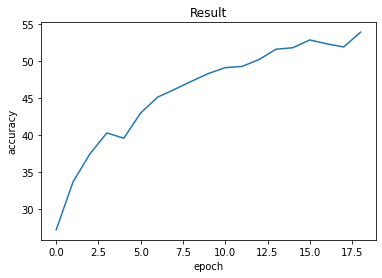

In [15]:
accuracy=[]
for epoch in range(1, 20):
    train(epoch)
    accuracy.append(test(epoch))

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(accuracy))], accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Result')
plt.show()